In [413]:
"""
Qick based qubit measurement example (maybe LC tank?)

RF Out     ____~~~~~~~~~~~~~~~~~~~~. . . .~~~~~~~~~~~~~~~~~~~~___
Digitizer  ____|‾‾‾‾‾|_|‾‾‾‾‾|_|‾‾‾. . . .‾‾‾|_|‾‾‾‾‾|_|‾‾‾‾‾|___
Measured Data   IQ[0]   IQ[1]      . . . .      IQ[78]  IQ[79]
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.averager_program import QickSweep
from qick.pyro import make_proxy

class LongDurationPulseExample(RAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["start"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = int(cfg["pulse_time"] * 3/4) - 10,    # Readout length
                                                            # 10 is subtracted to
                                                            # make margin in timing
        )
        (self.ro_rp, self.ro_freq) = self._ro_regmap[0, "freq"]
        (self.gen_rp, self.gen_freq) = self._gen_regmap[0, "freq"]
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        self.freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 16,       # Dummy length
            phrst   = 0,        # Readout DDS phase reset
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.synci(100000)

    def body(self):
        cfg = self.cfg
        # Put the generator's frequency register to temporary register (page : 0, register : 6)
        self.mathi(self.gen_rp, 6, self.gen_freq, '+', 0)
        self.mathi(self.ro_rp, 6, self.ro_freq, '+', 0)
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        # Set demodulator DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 16,       # Dummy length
            phrst   = 0,        # Readout DDS phase reset
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        
        self.mathi(self.ro_rp, self.ro_freq, 6, '+', 0)
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        # Make measurement triggers and shift t_sync
        for i in range(cfg["number_of_pulse"]):
            self.trigger(
                adcs    = [0],      # Readout channels
                adc_trig_offset = 150 # Readout will capture the data @ sync_t + 50
            )
            self.sync_all()
        
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = 0,  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        self.sync_all(10000)
        # Make sure that do not read buffer before experiment ends
        self.wait_all()
    
    def update(self): 
        # Update readout frequency register 
        self.mathi(
            self.ro_rp, self.ro_freq, self.ro_freq, '+',
            self.freq2reg_adc(self.cfg["step"], 0, 0)
        )
        # Update generator frequency register
        self.mathi(
            self.gen_rp, self.gen_freq, self.gen_freq, '+',
            self.freq2reg(self.cfg["step"], 0, 0)
        )
        self.synci(1000)



In [500]:
from scipy import stats
import json

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")
# print(soccfg)

att1 = 23
att2 = 30
# Set DAC Channel 0 attenuation 10 dB and 10 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,att1,att2)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

gain = [1, int(10 ** (1/2)), 10, int(10 ** (3/2)), 100, int(10 ** (5/2)), 1000,  int(10 ** (7/2))]
meas_numbers = [1, 4, 8, 80, 800]
meas_power = {}
meas_phase = {}
meas_unwrap_phase = {}
meas_unwrap_sub_phase = {}
for meas_number in meas_numbers:
    for x in gain:
        input_pwr = 20 * np.log10(rf_gain) - 77 - att1 - att2
        rf_gain = x
        start_time = time.time()
        cfg = {
            # Experiment Setup
            "reps" : 1,
            "expts" : 320,
            "start" : 500,
            "step" : 0.25,
            "gain" : rf_gain,
            # Parameter Setup
            "pulse_time" : 50000,
            "number_of_pulse" : meas_number,
        }
        if meas_number == 1:
            cfg["pulse_time"] = 20000
        meas_time = cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6
        print("meas time : {:.3f} ms".format(meas_time))
        cfg["gain"] = x
        prog = LongDurationPulseExample(
            soccfg,
            cfg,
        )
        expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
        end_time = time.time()
        avgi = np.array(avgi[0]).mean(axis = 0)
        avgq = np.array(avgq[0]).mean(axis = 0)
        meas_power[input_pwr] = 20 * np.log10(np.sqrt(avgi * avgi + avgq * avgq))
        meas_phase[input_pwr] = np.angle(avgi + 1j * avgq)

        print(f"Acquisition time for : {end_time - start_time} s")
        plt.figure()
        plt.ylabel("relative mag [dB]")
        plt.xlabel("freq [MHz]")
        plt.plot(expts, meas_power[input_pwr], label = str(x))
        plt.savefig("meas time {:.3f} ms_{:.1f} dBm_pwr.png".format(meas_time, input_pwr))
        plt.figure()
        plt.ylabel("phase [rad]")
        plt.xlabel("freq [MHz]")
        plt.plot(expts, meas_phase[input_pwr])
        plt.savefig("meas time {:.3f} ms_{:.1f} dBm_phase.png".format(meas_time, input_pwr))
        # plt.show()

        plt.figure()
        plt.ylabel("unwrapped ang [rad]")
        plt.xlabel("freq [MHz]")
        plt.plot(expts, np.unwrap(list(meas_phase[input_pwr])))
        plt.savefig("meas time {:.3f} ms_{:.1f} dBm_unwrapped ang.png".format(meas_time, input_pwr))

        meas_phase_uw = np.unwrap(list(meas_phase[input_pwr]))
        meas_unwrap_phase[input_pwr] = meas_phase_uw
        slope, intercept, r_value, p_value, std_err = stats.linregress(expts[:200], meas_phase_uw[:200])
        meas_phase_uw = meas_phase_uw - expts * slope - intercept
        plt.figure()
        plt.plot(expts, meas_phase_uw)
        plt.ylabel("unwrapped ang with sub [rad]")
        plt.xlabel("freq [MHz]")
        plt.savefig("meas time {:.3f} ms_{:.1f} dBm_unwrapped unwrapped ang with sub.png".format(meas_time, input_pwr))
        # plt.show()
        meas_unwrap_sub_phase[input_pwr] = meas_phase_uw



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_4e4a87e885d1473091c53bd4c2c7c826@192.168.2.99:44075
meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10888.02it/s]

Acquisition time for : 0.05593609809875488 s


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 11037.64it/s]

Acquisition time for : 0.053587913513183594 s


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10895.00it/s]

Acquisition time for : 0.055728912353515625 s


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10600.29it/s]

Acquisition time for : 0.06047773361206055 s


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10732.01it/s]

Acquisition time for : 0.057128190994262695 s


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10742.32it/s]

Acquisition time for : 0.05536174774169922 s



C:\Users\Measurement1\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10842.81it/s]

Acquisition time for : 0.05594277381896973 s


meas time : 0.050 ms


100%|██████████| 320/320 [00:00<00:00, 10959.59it/s]

Acquisition time for : 0.0571744441986084 s


meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1820.19it/s]


Acquisition time for : 0.20195674896240234 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1839.99it/s]


Acquisition time for : 0.20010089874267578 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1833.32it/s]


Acquisition time for : 0.19912981986999512 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1832.71it/s]


Acquisition time for : 0.20409607887268066 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1826.55it/s]


Acquisition time for : 0.20189738273620605 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1826.25it/s]


Acquisition time for : 0.20049738883972168 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1836.54it/s]


Acquisition time for : 0.19856524467468262 s
meas time : 0.500 ms


100%|██████████| 320/320 [00:00<00:00, 1841.04it/s]


Acquisition time for : 0.20283150672912598 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 954.10it/s]


Acquisition time for : 0.3653743267059326 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 958.05it/s]


Acquisition time for : 0.36199474334716797 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 960.20it/s]


Acquisition time for : 0.36268138885498047 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 958.43it/s]


Acquisition time for : 0.3586387634277344 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 955.48it/s]


Acquisition time for : 0.3702223300933838 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 957.88it/s]


Acquisition time for : 0.3615570068359375 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 955.75it/s]


Acquisition time for : 0.3648681640625 s
meas time : 1.000 ms


100%|██████████| 320/320 [00:00<00:00, 953.98it/s]


Acquisition time for : 0.3650345802307129 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.19it/s] 


Acquisition time for : 3.2628591060638428 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.26it/s]


Acquisition time for : 3.2585790157318115 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.28it/s]


Acquisition time for : 3.260531187057495 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.19it/s] 


Acquisition time for : 3.2594146728515625 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.31it/s]


Acquisition time for : 3.2643959522247314 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.30it/s]


Acquisition time for : 3.2557382583618164 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.27it/s]


Acquisition time for : 3.2588088512420654 s
meas time : 10.000 ms


100%|██████████| 320/320 [00:03<00:00, 99.32it/s]


Acquisition time for : 3.259748697280884 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.21287655830383 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.19639563560486 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.2083899974823 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.21093034744263 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.24360513687134 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.64145851135254 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.19435214996338 s
meas time : 100.000 ms


100%|██████████| 320/320 [00:32<00:00,  9.97it/s]


Acquisition time for : 32.20207095146179 s


In [499]:
save_data = {
    "freqs" : list(expts),
    "pwr" : {key : list(val) for key, val in meas_power.items()},
    "phase" : {key : list(val) for key, val in meas_phase.items()},
    "meas_unwrap_phase" : {key : list(val) for key, val in meas_unwrap_phase.items()},
    "meas_unwrap_sub_phase" : {key : list(val) for key, val in meas_unwrap_sub_phase.items()},
}
with open("Meas_20251003.json", "w", encoding = "utf-8") as f:
    json.dump(save_data, f, indent = 4)
    f.close()

In [7]:
%matplotlib qt

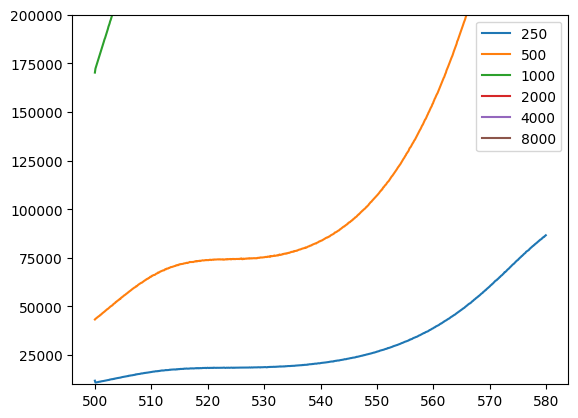

In [28]:

plt.figure()
for x in gain:
    plt.plot(expts, meas_power[x], label = str(x))
plt.legend()
plt.ylim([0.01e6, 0.2e6])
plt.show()

In [34]:

t_exps = [1e-3, 0.5e-3, 100e-6, 50e-6]
for idx, t_exp in enumerate(t_exps):
    start_time = time.time()
    cfg = {
        # Experiment Setup
        "reps" : 1,
        "expts" : 250,
        "start" : 500,
        "step" : 0.32,
        "gain" : 2000,
        # Parameter Setup
        "pulse_time" : 65000,
        "number_of_pulse" : 1,
    }
    cfg["number_of_pulse"] = int(t_exp * 1e9 / (2.5*cfg["pulse_time"])) + 1
    if cfg["number_of_pulse"] == 1:
        cfg["pulse_time"] = int(t_exp * 1e9 / 2.5)
    print("meas time : {:.3f} ms".format(cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6 ))
    # print(prog)
    plt.figure()
    gain = [1000]
    meas_power = {}
    meas_phase = {}
    for x in (gain):
        cfg["gain"] = x
        prog = LongDurationPulseExample(
            soccfg,
            cfg,
        )
        expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
        end_time = time.time()
        avgi = np.array(avgi[0]).mean(axis = 0)
        avgq = np.array(avgq[0]).mean(axis = 0)
        meas_power[x] = np.sqrt(avgi * avgi + avgq * avgq)
        meas_phase[x] = np.angle(avgi + 1j * avgq)

        print(f"Acquisition time for : {end_time - start_time} s")
        plt.plot(expts, meas_power[x], label = str(x))
    plt.legend()
    plt.savefig(f"{idx}_{t_exp}_volt.png")
    plt.figure()
    for x in gain:
        plt.plot(expts, meas_phase[x], label = str(x))
    plt.legend()
    plt.savefig(f"{idx}_{t_exp}_phase.png")

meas time : 1.137 ms


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:00<00:00, 881.10it/s]


Acquisition time for : 0.35033631324768066 s
meas time : 0.650 ms


100%|██████████| 250/250 [00:00<00:00, 1508.80it/s]


Acquisition time for : 0.24384832382202148 s
meas time : 0.100 ms


100%|██████████| 250/250 [00:00<00:00, 6925.36it/s]

Acquisition time for : 0.1207575798034668 s


meas time : 0.050 ms


100%|██████████| 250/250 [00:00<00:00, 13451.39it/s]

Acquisition time for : 0.0806577205657959 s


In [38]:

gain = [10, 100, 1000, 10000]
start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 250,
    "start" : 500,
    "step" : 0.32,
    "gain" : 2000,
    # Parameter Setup
    "pulse_time" : 65000,
    "number_of_pulse" : 10,
}
print("meas time : {:.3f} ms".format(cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6 ))
# print(prog)
plt.figure()
meas_power = {}
meas_phase = {}
for x in (gain):
    cfg["gain"] = x
    prog = LongDurationPulseExample(
        soccfg,
        cfg,
    )
    expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
    end_time = time.time()
    avgi = np.array(avgi[0]).mean(axis = 0)
    avgq = np.array(avgq[0]).mean(axis = 0)
    meas_power[x] = np.sqrt(avgi * avgi + avgq * avgq)
    meas_phase[x] = np.angle(avgi + 1j * avgq)

    print(f"Acquisition time for : {end_time - start_time} s")
    plt.plot(expts, meas_power[x], label = str(x))
    plt.legend()
    plt.savefig(f"gain_{x}_volt.png")
    plt.figure()
    plt.plot(expts, meas_phase[x], label = str(x))
    plt.legend()
    plt.savefig(f"gain_{x}_phase.png")

meas time : 1.625 ms


100%|██████████| 250/250 [00:00<00:00, 610.55it/s]


Acquisition time for : 0.4938530921936035 s


100%|██████████| 250/250 [00:00<00:00, 602.51it/s]


Acquisition time for : 1.324974775314331 s


100%|██████████| 250/250 [00:00<00:00, 613.22it/s]


Acquisition time for : 2.068647623062134 s


100%|██████████| 250/250 [00:00<00:00, 607.59it/s]


Acquisition time for : 2.8384108543395996 s


In [323]:

start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 1,
    "start" : 500,
    "step" : 0.32,
    "gain" : 1000,
    # Parameter Setup
    "pulse_time" : 65000,
    "number_of_pulse" : 10,
}
print("meas time : {:.3f} ms".format(cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6 ))
# print(prog)
plt.figure()

meas_power = []
meas_phase = []

freqs = np.linspace(500, 580, 1000)
for x in (freqs):
    prog = LongDurationPulseExample(
        soccfg,
        cfg,
    )
    cfg["start"] = x
    expts, avgi, avgq  = prog.acquire(soc = soc, progress = False, start_src = "internal")
    end_time = time.time()
    avgi = np.array(avgi[0]).mean(axis = 0)
    avgq = np.array(avgq[0]).mean(axis = 0)
    meas_power.append(np.sqrt(avgi * avgi + avgq * avgq)[0])
    meas_phase.append(np.angle(avgi + 1j * avgq)[0])

print(f"Acquisition time for : {end_time - start_time} s")
plt.plot(freqs, meas_power)
plt.savefig(f"soft_volt.png")
plt.figure()
plt.plot(freqs, meas_phase)
plt.savefig(f"soft_phase.png")

meas time : 1.625 ms
Acquisition time for : 27.3564875125885 s


In [ ]:
plt.figure()
plt.plot(freqs, meas_power)
plt.figure()
plt.plot(freqs, meas_phase)

In [63]:
with open("soft.txt", "w", encoding = "utf-8") as f:
    f.write(str(meas_power))
    f.write("\n")
    f.write(str(meas_phase))

In [325]:
from scipy import stats

meas_phase_uw = np.unwrap(meas_phase)
slope, intercept, r_value, p_value, std_err = stats.linregress(freqs[:200], meas_phase_uw[:200])
meas_phase_uw = meas_phase_uw - freqs * slope - intercept
plt.plot(freqs, meas_phase_uw)
plt.show()

with open("soft_bg_sub.txt", "w", encoding = "utf-8") as f:
    f.write(str(meas_phase_uw))

In [407]:
print(prog)


// Program

        regwi 0, $22, 335544321;                //freq = 335544321
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1000;                     //gain = 1000
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 894784856;                //freq = 894784856
        regwi 4, $26, 262160;                   //mode | outsel = 0b00100 | length = 16 
        synci 100000;
        regwi 0, $13, 0;
        regwi 0, $14, 319;
LOOP_I: regwi 0, $15, 0;
LOOP_J: mathi 0, $6, $22 + 0;
        mathi 4, $6, $22 + 0;
        regwi 0, $22, 335544321;                //freq = 335544321
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1000;                     //gain = 1000
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 894784856;                //freq = 894784856
        r